## Static Analysis
* calculating static values for each timeseries, like min, max, mean etc
* apply various feature selection algorithms
* train various models and compare results

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [25]:
# own libraries
import importlib
import utilities.filter_acc_data as filter_acc_data
import utilities.feature_generation as feature_generation
import utilities.data_controller as data_controller
import utilities.feature_selection_own as feature_selection_own
importlib.reload(filter_acc_data)
importlib.reload(feature_generation)
importlib.reload(data_controller)
importlib.reload(feature_selection_own)

<module 'utilities.feature_selection_own' from 'C:\\Users\\phil\\university\\verona\\machine-learning-project-human-activity-recognition\\utilities\\feature_selection_own.py'>

In [26]:
# read all acc and gyro data
filepath_raw = 'dataset/HAPT-Dataset/'
all_acc_data, all_gyro_data = data_controller.get_all_acc_and_gyro_data_from_txt(filepath_raw)

# get labels and indexes for each activity
label_translation, activity_indexes = data_controller.get_label_and_activity_indexes_from_txt(filepath_raw)

In [27]:
# turn acc data into gravity and body components using low and highpass filter
# Filter settings
sample_frequenzy = 50.0
cutoff_low_hz = 0.25
cutoff_high_hz = 20
filter_order = 3

grav_and_body_acc_data = \
    [filter_acc_data.get_gravitational_and_body_components(acc_data, sample_frequenzy, cutoff_low_hz, cutoff_high_hz, filter_order) 
     for acc_data in all_acc_data]

all_acc_gravity_data = [grav_data[0] for grav_data in grav_and_body_acc_data]
all_acc_body_data = [grav_data[1] for grav_data in grav_and_body_acc_data]
all_acc_noise_data = [grav_data[2] for grav_data in grav_and_body_acc_data]

In [28]:
# transform raw data into object with each activity and the belonging data as entry
use_filtered_data = True
if use_filtered_data:
    data = data_controller.transform_raw_data_into_data_object(label_translation, activity_indexes, all_acc_data, all_acc_gravity_data, all_acc_body_data, all_gyro_data, all_acc_noise_data)
else:
    data = data_controller.transform_raw_data_into_data_object(label_translation, activity_indexes, all_acc_data, all_acc_gravity_data, all_acc_body_data, all_gyro_data, all_acc_noise_data, include_gravity_data=False, include_body_data=False, include_raw_acc_data=True)
data[0]['data'][0].head()

gyro_X    gyro_Y    gyro_Z  acc_body_X  acc_body_Y  acc_body_Z  \
0 -0.675922  0.670425 -0.083383   -0.006551    0.022637   -0.070557   
1 -1.133461 -0.391565  0.118813   -0.320667    0.164856   -0.070158   
2 -1.290758 -0.763582  0.105680   -0.269801    0.143633   -0.079335   
3 -1.204932 -0.759611  0.034514   -0.051350   -0.038957   -0.102231   
4 -0.853073 -0.632551 -0.087048    0.048986   -0.175093   -0.100550   

   acc_gravity_X  acc_gravity_Y  acc_gravity_Z  
0       1.005002      -0.226667      -0.038793  
1       1.004954      -0.226458      -0.038915  
2       1.004907      -0.226258      -0.039035  
3       1.004860      -0.226069      -0.039155  
4       1.004815      -0.225890      -0.039272

In [29]:
print("activities and number of measurements")
for entry in data:
    print(entry['name'], len(entry['data']))

activities and number of measurements
WALKING 127
WALKING_UPSTAIRS 183
WALKING_DOWNSTAIRS 186
SITTING 120
STANDING 120
LAYING 120
STAND_TO_SIT 60
SIT_TO_STAND 62
SIT_TO_LIE 60
LIE_TO_SIT 60
STAND_TO_LIE 58
LIE_TO_STAND 58


In [30]:
# now generate features for each activity
activities_to_use = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']  # dont use transition activities, only the 6 main ones
static_data = feature_generation.generate_features_for_each_activity(data, activities_to_use)
static_data.head()

activity_name  gyro_X_min  gyro_X_max  gyro_X_mean  gyro_X_std  \
0       WALKING   -1.741271    0.884227    -0.096601    0.546266   
1       WALKING   -1.574200    1.144456    -0.007132    0.481832   
2       WALKING   -1.548238    1.249525    -0.007884    0.476685   
3       WALKING   -1.401325    1.134682    -0.009143    0.475924   
4       WALKING   -1.390940    1.018007    -0.009003    0.427251   

   gyro_X_median  gyro_X_var  gyro_X_skew  gyro_X_kurtosis  gyro_X_iqr  ...  \
0      -0.021838    0.298407    -0.527852        -0.313679    0.798554  ...   
1       0.063835    0.232162    -0.509122        -0.045516    0.642554  ...   
2       0.057574    0.227228    -0.531706         0.224295    0.614301  ...   
3       0.057727    0.226503    -0.514346        -0.031468    0.595135  ...   
4       0.046120    0.182543    -0.586121         0.444370    0.555811  ...   

   acc_gravity_x_y_angle  acc_gravity_x_z_angle  acc_gravity_y_z_angle  \
0               1.800451               1.604804              -1.715081   
1               1.799129               1.601748              -1.702497   
2               1.806175               1.603395              -1.704967   
3               1.799546               1.601377              -1.700539   
4               1.855649               1.682891              -1.937545   

   gyro_corr_xy  gyro_corr_xz  gyro_corr_yz  gyro_magnitude_mean  \
0     -0.011320      0.048233      0.065876             0.894848   
1      0.034846     -0.007143      0.014407             0.864187   
2      0.109731     -0.000699      0.039718             0.890730   
3      0.015397     -0.010690      0.053414             0.851424   
4      0.107007     -0.165217      0.142482             0.753746   

   gyro_x_y_angle  gyro_x_z_angle  gyro_y_z_angle  
0        0.083885       -0.079111       -0.170817  
1        0.364157        0.145392       -0.271014  
2        0.360085        0.208275       -0.222228  
3        0.346343        0.152424       -0.261108  
4        0.198584        0.164811       -0.131974  

[5 rows x 130 columns]

In [31]:
# create X and y data
X, y, X_column_names = feature_generation.create_X_and_y(static_data)
X_train, _, y_train, _ = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2, scale_data=False)

In [32]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (684, 129)
y_train shape: (684,)


## Feature Selection
* important: run feature selection on train data only, not on test data. Else we might "learn" something we should not know yet.

In [33]:
results_feature_selection = []

## All features
* class similar to sklearn feature classes which just returns the data without any feature selection

In [34]:
class AllFeatureSelector:
    @staticmethod
    def transform(X):
        return X

afs = AllFeatureSelector()

all_feature_selector = {'name': 'All', 'selector': afs}
results_feature_selection.append(all_feature_selector)
print(X_train.shape)

(684, 129)


### Variance Threshold
* manual implementation
* sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

#### NOTE: run variance threshold on non-scaled data, else (obviously) does not work

In [35]:
# Manual implementation of variance threshold
X_train, _, _, _ = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2, scale_data=False)
columns_above_threshold = feature_selection_own.variance_threshold_return_columns_above_threshold(X_train, X_column_names, threshold=0.9)
print("count_above_threshold:", columns_above_threshold)

variance_threshold_return_columns_above_threshold count: 37
count_above_threshold: ['gyro_X_min', 'gyro_X_skew', 'gyro_X_kurtosis', 'gyro_X_energy', 'gyro_X_max_to_min', 'gyro_X_max_to_min_diff', 'gyro_Y_max', 'gyro_Y_skew', 'gyro_Y_kurtosis', 'gyro_Y_energy', 'gyro_Y_max_to_min_diff', 'gyro_Z_skew', 'gyro_Z_kurtosis', 'gyro_Z_energy', 'gyro_Z_max_to_min_diff', 'acc_body_X_skew', 'acc_body_X_kurtosis', 'acc_body_X_energy', 'acc_body_Y_skew', 'acc_body_Y_kurtosis', 'acc_body_Y_energy', 'acc_body_Z_skew', 'acc_body_Z_kurtosis', 'acc_body_Z_energy', 'acc_gravity_X_skew', 'acc_gravity_X_kurtosis', 'acc_gravity_X_energy', 'acc_gravity_X_max_to_min', 'acc_gravity_Y_skew', 'acc_gravity_Y_kurtosis', 'acc_gravity_Y_energy', 'acc_gravity_Y_max_to_min', 'acc_gravity_Z_skew', 'acc_gravity_Z_kurtosis', 'acc_gravity_Z_energy', 'acc_gravity_Z_max_to_min', 'acc_gravity_y_z_angle']


In [36]:
from sklearn.feature_selection import VarianceThreshold
X_train, _, _, _ = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2, scale_data=False)
sel_var = VarianceThreshold(threshold=0.9)
X_train_var = sel_var.fit_transform(X_train)
print(X_train_var.shape)

result_variance_threshold = {'name': 'Variance Threshold', 'selector': sel_var}
results_feature_selection.append(result_variance_threshold)

(684, 37)


In [37]:
print("Selected columns:")
print(*X_column_names[sel_var.get_support(indices=True)])

Selected columns:
gyro_X_min gyro_X_skew gyro_X_kurtosis gyro_X_energy gyro_X_max_to_min gyro_X_max_to_min_diff gyro_Y_max gyro_Y_skew gyro_Y_kurtosis gyro_Y_energy gyro_Y_max_to_min_diff gyro_Z_skew gyro_Z_kurtosis gyro_Z_energy gyro_Z_max_to_min_diff acc_body_X_skew acc_body_X_kurtosis acc_body_X_energy acc_body_Y_skew acc_body_Y_kurtosis acc_body_Y_energy acc_body_Z_skew acc_body_Z_kurtosis acc_body_Z_energy acc_gravity_X_skew acc_gravity_X_kurtosis acc_gravity_X_energy acc_gravity_X_max_to_min acc_gravity_Y_skew acc_gravity_Y_kurtosis acc_gravity_Y_energy acc_gravity_Y_max_to_min acc_gravity_Z_skew acc_gravity_Z_kurtosis acc_gravity_Z_energy acc_gravity_Z_max_to_min acc_gravity_y_z_angle


### LDA - Linear Discriminant Analysis
* manual implementation of LDA
* sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

In [38]:
# manual implementation
X_train, X_test, y_train, y_test = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2)
X_transformed, eigenvalues_sorted = feature_selection_own.linear_discriminant_analysis_transform_data(X_train, y_train, n_components=5)
print(X_transformed.shape)

(684, 5)


In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2)
clf_lda = LinearDiscriminantAnalysis(solver='svd', n_components=5)
X_train_lda = clf_lda.fit_transform(X_train, y_train)
print(X_train_lda.shape)

result_lda = {'name': 'LDA', 'selector': clf_lda}
results_feature_selection.append(result_lda)

(684, 5)


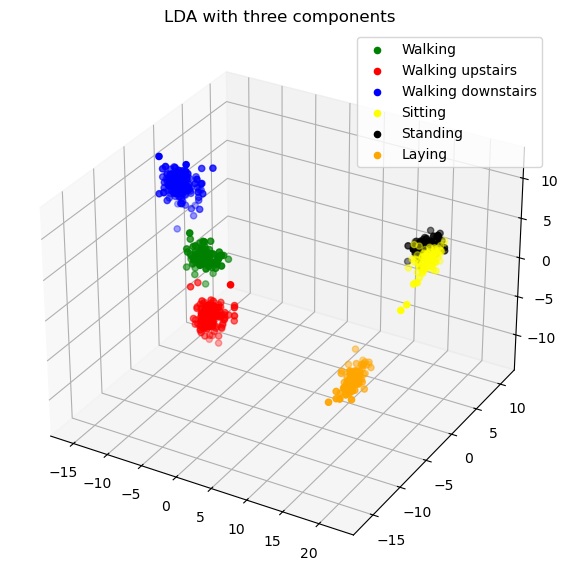

In [40]:
# plotting LDA with 3 components
clf_lda_plot = LinearDiscriminantAnalysis(solver='svd', n_components=5)
X_train_lda_plot = clf_lda_plot.fit_transform(X_train, y_train)
class_zero = X_train_lda_plot[y_train == 0]
class_one = X_train_lda_plot[y_train == 1]
class_two = X_train_lda_plot[y_train == 2]
class_three = X_train_lda_plot[y_train == 3]
class_four = X_train_lda_plot[y_train == 4]
class_five = X_train_lda_plot[y_train == 5]
# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.scatter3D(class_zero[:, 0], class_zero[:, 1], class_zero[:, 2], color="green", label="Walking")
ax.scatter3D(class_one[:, 0], class_one[:, 1], class_one[:, 2], color="red", label = "Walking upstairs")
ax.scatter3D(class_two[:, 0], class_two[:, 1], class_two[:, 2], color="blue", label = "Walking downstairs")
ax.scatter3D(class_three[:, 0], class_three[:, 1], class_three[:, 2], color="yellow", label = "Sitting")
ax.scatter3D(class_four[:, 0], class_four[:, 1], class_four[:, 2], color="black", label = "Standing")
ax.scatter3D(class_five[:, 0], class_five[:, 1], class_five[:, 2], color="orange", label = "Laying")
plt.legend()
plt.title("LDA with three components")

plt.show()

### PCA - Principal Component Analysis
* manual implementation of PCA
* and sklearn implementatino https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [41]:
# manually applying PCA
X_train, X_test, y_train, y_test = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2)
X_transformed = feature_selection_own.principal_component_analysis_transform_data(X_train, n_components=10)
print(X_transformed.shape)

(684, 10)


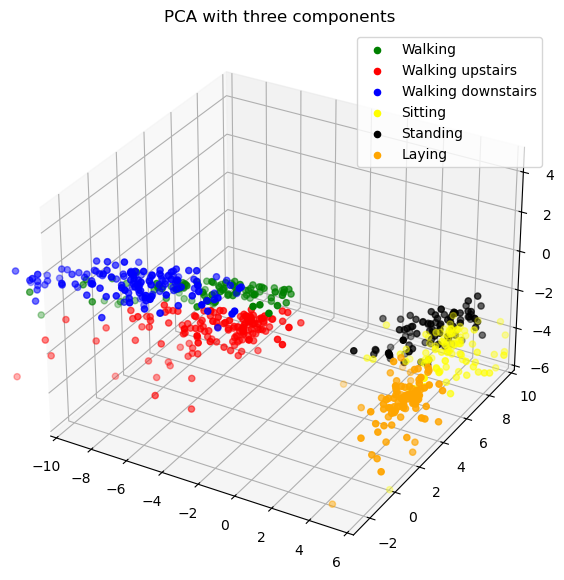

In [42]:
# plotting PCA with 3 components
X_transformed = feature_selection_own.principal_component_analysis_transform_data(X_train, n_components=3)
class_zero = X_transformed[y_train == 0]
class_one = X_transformed[y_train == 1]
class_two = X_transformed[y_train == 2]
class_three = X_transformed[y_train == 3]
class_four = X_transformed[y_train == 4]
class_five = X_transformed[y_train == 5]
# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(class_zero[:, 0], class_zero[:, 1], class_zero[:, 2], color="green", label="Walking")
ax.scatter3D(class_one[:, 0], class_one[:, 1], class_one[:, 2], color="red", label = "Walking upstairs")
ax.scatter3D(class_two[:, 0], class_two[:, 1], class_two[:, 2], color="blue", label = "Walking downstairs")
ax.scatter3D(class_three[:, 0], class_three[:, 1], class_three[:, 2], color="yellow", label = "Sitting")
ax.scatter3D(class_four[:, 0], class_four[:, 1], class_four[:, 2], color="black", label = "Standing")
ax.scatter3D(class_five[:, 0], class_five[:, 1], class_five[:, 2], color="orange", label = "Laying")
ax.set_xlim([-10, 6])
ax.set_ylim([-3, 10])
ax.set_zlim([-6, 5])
plt.legend()
plt.title("PCA with three components")
plt.show()

In [43]:
from sklearn.decomposition import PCA
# if n_components is float: select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components
# svd_solver{‘auto’, ‘full’, ‘arpack’, ‘randomized’}, default=’auto’
sel_pca = PCA(n_components=10, svd_solver='auto')
X_train_pca = sel_pca.fit_transform(X_train)
print(X_train_pca.shape)

result_pca = {'name': 'PCA', 'selector': sel_pca}
results_feature_selection.append(result_pca)

(684, 10)


### RFECV - Recursive Feature Elimination with Cross-Validation
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [44]:
# use 3 fixed number of features to plot
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
estimator = SVC(kernel='linear')  # needs to use kernel linear
sel_rfe = RFE(estimator, n_features_to_select=3, step=1)
X_train_rfe = sel_rfe.fit_transform(X_train, y_train)
print(X_train_rfe.shape)

result_rfe = {'name': 'RFE', 'selector': sel_rfe}
results_feature_selection.append(result_rfe)

(684, 3)


In [45]:
X_column_names[sel_rfe.get_support(indices=True)]

Index(['acc_body_Y_std', 'acc_gravity_X_energy', 'gyro_x_y_angle'], dtype='object')

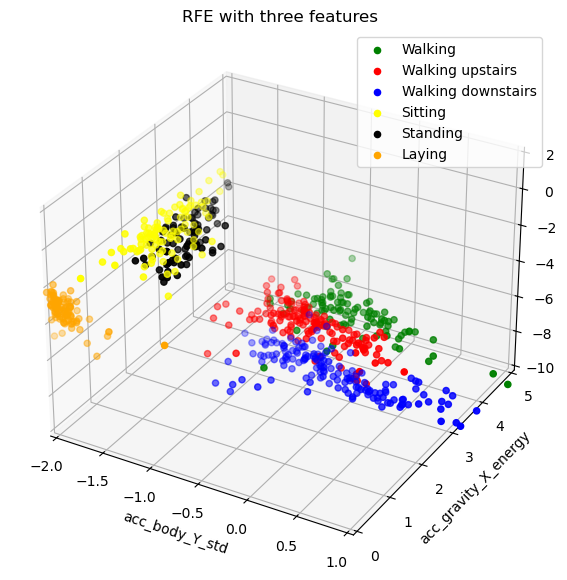

In [46]:
columns = X_column_names[sel_rfe.get_support(indices=True)]
class_zero = X_train_rfe[y_train == 0]
class_one = X_train_rfe[y_train == 1]
class_two = X_train_rfe[y_train == 2]
class_three = X_train_rfe[y_train == 3]
class_four = X_train_rfe[y_train == 4]
class_five = X_train_rfe[y_train == 5]
# Creating figure
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(class_zero[:, 0], class_zero[:, 1], class_zero[:, 2], color="green", label="Walking")
ax.scatter3D(class_one[:, 0], class_one[:, 1], class_one[:, 2], color="red", label = "Walking upstairs")
ax.scatter3D(class_two[:, 0], class_two[:, 1], class_two[:, 2], color="blue", label = "Walking downstairs")
ax.scatter3D(class_three[:, 0], class_three[:, 1], class_three[:, 2], color="yellow", label = "Sitting")
ax.scatter3D(class_four[:, 0], class_four[:, 1], class_four[:, 2], color="black", label = "Standing")
ax.scatter3D(class_five[:, 0], class_five[:, 1], class_five[:, 2], color="orange", label = "Laying")
# set x label
ax.set_xlabel(columns[0])
ax.set_ylabel(columns[1])
ax.set_zlabel(columns[2])
ax.set_xlim([-2, 1])
ax.set_ylim([0, 5])
ax.set_zlim([-10, 2])
plt.legend()
plt.title("RFE with three features")
plt.show()

In [42]:
# use cross validation to find optimal number of features
from sklearn.feature_selection import RFECV
estimator = SVC(kernel="linear")
sel_rfecv = RFECV(estimator, step=1, cv=5)
X_train_rfecv = sel_rfecv.fit_transform(X_train, y_train)
print(X_train_rfecv.shape)

result_rfecv = {'name': 'RFECV', 'selector': sel_rfecv}
results_feature_selection.append(result_rfecv)

(684, 12)


In [43]:
X_column_names[sel_rfecv.get_support(indices=True)]

Index(['gyro_X_mean', 'gyro_X_std', 'gyro_Y_iqr', 'gyro_Z_std', 'gyro_Z_iqr',
       'acc_X_min', 'acc_X_max', 'acc_X_energy', 'acc_Y_max', 'acc_Y_iqr',
       'gyro_x_y_angle', 'acc_magnitude_mean'],
      dtype='object')

Now we have multiple feature selection results. We will use those for training various models and compare the results.

## Model Training and Evaluation
* for training the models we use GridSearchCV. This allows testing various parameters and also applying k-fold Cross-Validation as default


In [44]:
from sklearn.model_selection import GridSearchCV
X, y, X_column_names = feature_generation.create_X_and_y(static_data)  # reload to be sure nothing was manipulated
model_results = []

### SVC

In [45]:
grid_search_svc_parameters = {'C':[0.5, 1, 2,8,16], 'gamma': [ 'auto', 0.125, 0.5, 1, 2], 'kernel': ['rbf', 'linear']}

for feature_selector in results_feature_selection:
    print(feature_selector['name'])
    # apply feature transform (after splitting, because splitting also applies StandardScaler)
    X_train, X_test, y_train, y_test = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2)
    X_train = feature_selector['selector'].transform(X_train)
    X_test = feature_selector['selector'].transform(X_test)
    print("X_train shape after transforming:", X_train.shape)
    
    # run model
    clf = GridSearchCV(SVC(), grid_search_svc_parameters, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_params = clf.best_params_
    model_results.append({'name': 'SVC', 'feature_selector': feature_selector, 'accuracy': accuracy, 'best_params': best_params, 'feature_count': X_train.shape[1]})
    print("Accuracy:", accuracy)
    print(confusion_matrix(y_test, y_pred))
    print(clf.best_params_)
    print()

All
X_train shape after transforming: (684, 86)
Accuracy: 0.9651162790697675
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 21  2  0]
 [ 0  0  0  2 31  0]
 [ 0  0  0  0  0 23]]
{'C': 0.5, 'gamma': 'auto', 'kernel': 'linear'}

Variance Threshold
X_train shape after transforming: (684, 28)
Accuracy: 0.9418604651162791
[[26  2  1  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 21  2  0]
 [ 0  0  0  5 28  0]
 [ 0  0  0  0  0 23]]
{'C': 2, 'gamma': 'auto', 'kernel': 'linear'}

LDA
X_train shape after transforming: (684, 5)
Accuracy: 0.9534883720930233
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 21  2  0]
 [ 0  0  0  3 30  0]
 [ 0  0  0  1  0 22]]
{'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}

PCA
X_train shape after transforming: (684, 10)
Accuracy: 0.9593023255813954
[[27  2  0  0  0  0]
 [ 1 32  0  0  0  0]
 [ 2  0 29  0  0  0]
 [ 0  0  0 22  1  0]
 [ 0  0  0  1 32  0]
 [ 0  0  0  0  0 23]]
{'C': 8, 'gamma': 'auto', 'kern

## Gradient Boosting Classifier
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_gs_parameters = {'n_estimators': [10, 100, 200], 'learning_rate': [0.1, 0.25, 0.5], 'max_depth': [1, 3, 5]}

for feature_selector in results_feature_selection:
    print(feature_selector['name'])
    # apply feature transform (after splitting, because splitting also applies StandardScaler)
    X_train, X_test, y_train, y_test = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2)
    X_train = feature_selector['selector'].transform(X_train)
    X_test = feature_selector['selector'].transform(X_test)
    
    # run model
    clf = GridSearchCV(GradientBoostingClassifier(), gbc_gs_parameters, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_params = clf.best_params_
    model_results.append({'name': 'GradientBoostingClassifier', 'feature_selector': feature_selector, 'accuracy': accuracy, 'best_params': best_params, 'feature_count': X_train.shape[1]})
    print("Accuracy:", accuracy)
    print(confusion_matrix(y_test, y_pred))
    print(clf.best_params_)
    print()

All
Accuracy: 0.9534883720930233
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 1  0 30  0  0  0]
 [ 0  0  0 20  3  0]
 [ 0  0  0  2 31  0]
 [ 0  0  0  0  0 23]]
{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}

Variance Threshold
Accuracy: 0.9302325581395349
[[24  3  1  0  0  1]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 19  4  0]
 [ 0  0  0  3 30  0]
 [ 0  0  0  0  0 23]]
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 200}

LDA
Accuracy: 0.9534883720930233
[[26  2  0  1  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 29  1  1  0]
 [ 0  0  0 22  1  0]
 [ 0  0  0  1 32  0]
 [ 0  0  0  1  0 22]]
{'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 100}

PCA
Accuracy: 0.9418604651162791
[[25  3  1  0  0  0]
 [ 0 33  0  0  0  0]
 [ 2  0 29  0  0  0]
 [ 0  0  0 22  1  0]
 [ 0  0  0  2 31  0]
 [ 0  0  0  1  0 22]]
{'learning_rate': 0.25, 'max_depth': 1, 'n_estimators': 200}

RFE
Accuracy: 0.936046511627907
[[28  1  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 1  0 30  0  0  0]
 [ 0

### Naive Bayes
* https://scikit-learn.org/stable/modules/naive_bayes.html

In [47]:
from sklearn.naive_bayes import GaussianNB

for feature_selector in results_feature_selection:
    print(feature_selector['name'])
    # apply feature transform (after splitting, because splitting also applies StandardScaler)
    X_train, X_test, y_train, y_test = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2)
    X_train = feature_selector['selector'].transform(X_train)
    X_test = feature_selector['selector'].transform(X_test)
    
    # run model
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_results.append({'name': 'GaussianNB', 'feature_selector': feature_selector, 'accuracy': accuracy, 'best_params': None, 'feature_count': X_train.shape[1]})
    print("GNB")
    print("Accuracy:", accuracy)
    print(confusion_matrix(y_test, y_pred))
    print()

All
GNB
Accuracy: 0.9534883720930233
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 19  4  0]
 [ 0  0  0  2 31  0]
 [ 0  0  0  0  0 23]]

Variance Threshold
GNB
Accuracy: 0.872093023255814
[[24  4  1  0  0  0]
 [ 0 31  2  0  0  0]
 [ 0  1 30  0  0  0]
 [ 0  0  0 20  3  0]
 [ 0  0  0 11 22  0]
 [ 0  0  0  0  0 23]]

LDA
GNB
Accuracy: 0.9767441860465116
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 22  1  0]
 [ 0  0  0  1 32  0]
 [ 0  0  0  0  0 23]]

PCA
GNB
Accuracy: 0.9244186046511628
[[24  5  0  0  0  0]
 [ 1 32  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 21  2  0]
 [ 0  0  0  5 28  0]
 [ 0  0  0  0  0 23]]

RFE
GNB
Accuracy: 0.936046511627907
[[28  1  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 1  0 30  0  0  0]
 [ 0  0  0 22  1  0]
 [ 2  0  0  6 25  0]
 [ 0  0  0  0  0 23]]

RFECV
GNB
Accuracy: 0.9593023255813954
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 1  0 30  0  0  0]
 [ 0  0  0 21  2  0]
 [ 0  0  0  2 31  0]
 [ 0  0  0  0  0 2

### LDA

In [48]:
for feature_selector in results_feature_selection:
    print(feature_selector['name'])
    # apply feature transform (after splitting, because splitting also applies StandardScaler)
    X_train, X_test, y_train, y_test = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=0.2)
    X_train = feature_selector['selector'].transform(X_train)
    X_test = feature_selector['selector'].transform(X_test)
    
    # run model
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_results.append({'name': 'LDA', 'feature_selector': feature_selector, 'accuracy': accuracy, 'best_params': None, 'feature_count': X_train.shape[1]})
    print("LDA")
    print("Accuracy:", accuracy)
    print(confusion_matrix(y_test, y_pred))
    print()


All
LDA
Accuracy: 0.9825581395348837
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 23  0  0]
 [ 0  0  0  1 32  0]
 [ 0  0  0  0  0 23]]

Variance Threshold
LDA
Accuracy: 0.9186046511627907
[[25  3  1  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  2 29  0  0  0]
 [ 0  0  0 21  2  0]
 [ 0  0  1  5 27  0]
 [ 0  0  0  0  0 23]]

LDA
LDA
Accuracy: 0.9825581395348837
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 23  0  0]
 [ 0  0  0  1 32  0]
 [ 0  0  0  0  0 23]]

PCA
LDA
Accuracy: 0.936046511627907
[[26  3  0  0  0  0]
 [ 2 31  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 22  1  0]
 [ 0  0  0  5 28  0]
 [ 0  0  0  0  0 23]]

RFE
LDA
Accuracy: 0.936046511627907
[[27  1  0  0  1  0]
 [ 0 33  0  0  0  0]
 [ 2  0 29  0  0  0]
 [ 0  0  0 19  4  0]
 [ 1  0  0  2 30  0]
 [ 0  0  0  0  0 23]]

RFECV
LDA
Accuracy: 0.9825581395348837
[[27  2  0  0  0  0]
 [ 0 33  0  0  0  0]
 [ 0  0 31  0  0  0]
 [ 0  0  0 22  1  0]
 [ 0  0  0  0 33  0]
 [ 0  0  0  0  0 2

# Results

In [49]:
sorted_model_results = sorted(model_results, key=lambda k: k['accuracy'], reverse=True)
# for result in sorted_model_results:
#     print("Model: %s, Selector: %s, Accuracy: %0.3f, Features: %d, Params: %s" % (result['name'], result['feature_selector']['name'], result['accuracy'], result['feature_count'] ,result['best_params']))

# Comparing Models
Comparing the best parameters for each model with the other models in regard to accuracy and learning time

## Plotting learning curves
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [50]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

# get best model parameters for each model
best_svc = next(obj for obj in sorted_model_results if obj['name'] == "SVC")
best_gradient_boosting = next(obj for obj in sorted_model_results if obj['name'] == "GradientBoostingClassifier")
best_gaussian = next(obj for obj in sorted_model_results if obj['name'] == "GaussianNB")
best_lda = next(obj for obj in sorted_model_results if obj['name'] == "LDA")

svc = SVC(**best_svc['best_params'])
gbc = GradientBoostingClassifier(**best_gradient_boosting['best_params'])
gnb = GaussianNB()
lda = LinearDiscriminantAnalysis()

# get learning curves
common_params = {
    "train_sizes": np.linspace(0.1, 1.0, 7),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=1905),
    "n_jobs": 4,
    "return_times": True,
}
X_all, _, y_all, _ = feature_generation.generate_train_test_split_and_scale_data(X, y, test_size=None)

train_sizes, _, test_scores_svc, fit_times_svc, _ = learning_curve(
    svc, best_svc['feature_selector']['selector'].transform(X_all), y_all, **common_params
)
_, _, test_scores_gbc, fit_times_gbc, _ = learning_curve(
    gbc, best_gradient_boosting['feature_selector']['selector'].transform(X_all), y_all, **common_params
)
_, _, test_scores_gnb, fit_times_gnb, _ = learning_curve(
    gnb, best_gaussian['feature_selector']['selector'].transform(X_all), y_all, **common_params
)

_, _, test_scores_lda, fit_times_lda, _ = learning_curve(
    lda, best_lda['feature_selector']['selector'].transform(X_all), y_all, **common_params
)

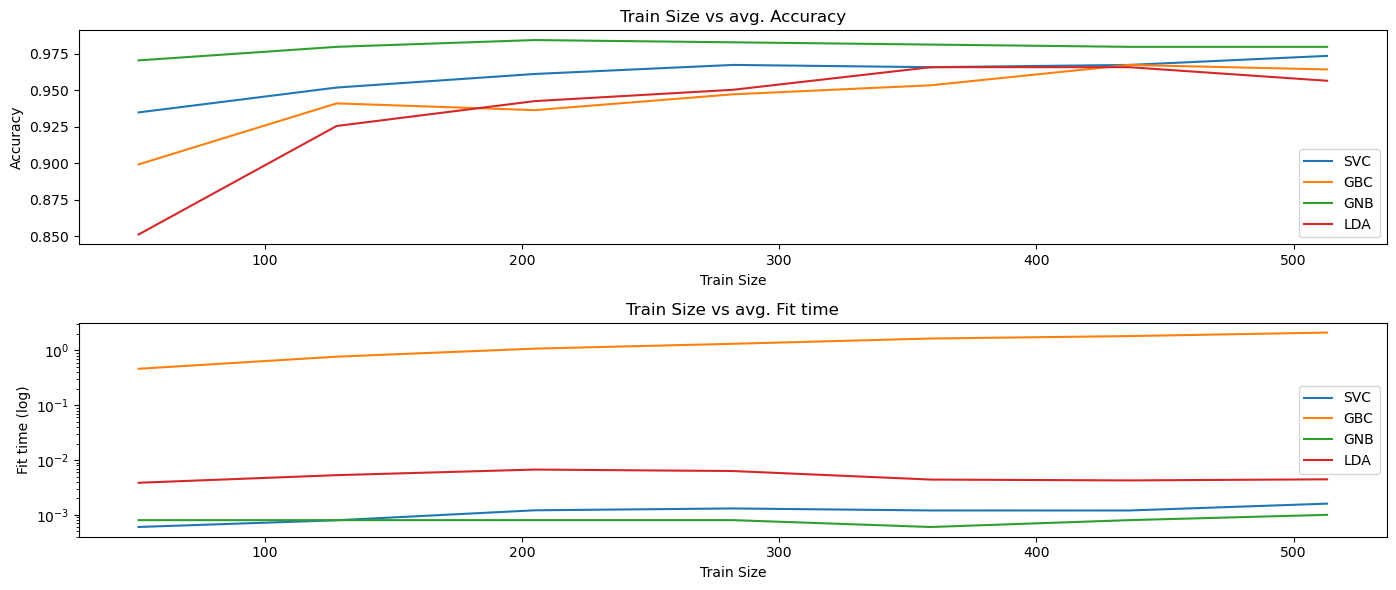

In [51]:
# plot results
plt.figure(figsize=(14,6))
plt.subplot(2, 1, 1)
plt.title('Train Size vs avg. Accuracy')
plt.plot(train_sizes, np.mean(test_scores_svc, axis=1), label='SVC')
plt.plot(train_sizes, np.mean(test_scores_gbc, axis=1), label='GBC')
plt.plot(train_sizes, np.mean(test_scores_gnb, axis=1), label='GNB')
plt.plot(train_sizes, np.mean(test_scores_lda, axis=1), label='LDA')
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.subplot(2, 1, 2)
plt.title('Train Size vs avg. Fit time')
plt.yscale("log") 
plt.plot(train_sizes, np.mean(fit_times_svc, axis=1), label='SVC')
plt.plot(train_sizes, np.mean(fit_times_gbc, axis=1), label='GBC')
plt.plot(train_sizes, np.mean(fit_times_gnb, axis=1), label='GNB')
plt.plot(train_sizes, np.mean(fit_times_lda, axis=1), label='LDA')
plt.xlabel('Train Size')
plt.ylabel('Fit time (log)')
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
print("feature counts:")
print("SVC:", best_svc['feature_count'])
print("GBC:", best_gradient_boosting['feature_count'])
print("GNB:", best_gaussian['feature_count'])

feature counts:
SVC: 12
GBC: 12
GNB: 5


In [53]:
print(best_lda)

{'name': 'LDA', 'feature_selector': {'name': 'All', 'selector': <__main__.AllFeatureSelector object at 0x0000026EA75F8100>}, 'accuracy': 0.9825581395348837, 'best_params': None, 'feature_count': 86}
